## Pre-requisites
Env: python 3.6, latest anaconda3 distribution  
Before running this notebook, make sure you have the following packages installed.
- kaggle api  
https://github.com/Kaggle/kaggle-api
- joblib  
conda install joblib  
Windows users are recommended to download and install the package directly from the github page https://github.com/joblib/joblib, as a Windows-specific bug was fixed in the recent master release but has not been pushed to conda repo yet.

## 2) Forecast the overnight stock price change direction

We want to forecast the direction of the overnight price change (between t0 close and t1 open prices) using the historical price and volume data. For instance, we use 01/05/2010's features as the training data and 01/06/2010's overnight price change direction as the training label to fit a model. Then we use 01/06/2010's features as the testing data and 01/07/2010's overnight price change direction as the testing label to evaluate the model. This process is repeated for all the dates available in the dataset. A trading strategy is formed using the model predictions that buys the stocks with predicted positive return at the market close price, and sell them the next day at the open price.  
  
We applied three models to explore the opportunity: random forest regressor, random forest classifer and and logistic regression. The random forest classifier model achieved the best results, however the precision rate is not good enough to form a profitable trading strategy.

In [1]:
import pandas as pd
import numpy as np
#import talib
import os
import sys
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.finance as mpf
import random
from joblib import Parallel, delayed

%matplotlib inline

C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


### Download Kaggle datasets

In [2]:
# !kaggle datasets download -d dgawlik/nyse -p ./datasets

### Load the data

In [3]:
fundamentals = pd.read_csv("./data/nyse/fundamentals.csv", parse_dates=['Period Ending'])
prices = pd.read_csv("./data/nyse/prices.csv", parse_dates=['date'])
prices_adj = pd.read_csv("./data/nyse/prices-split-adjusted.csv", parse_dates=['date'])
securities = pd.read_csv("./data/nyse/securities.csv", parse_dates=['Date first added'])

In [4]:
symbols = sorted(prices_adj['symbol'].unique())
prices_adj.set_index(['symbol', 'date'], inplace=True, drop=True)
prices_adj.sort_index(inplace=True)

### Plotting

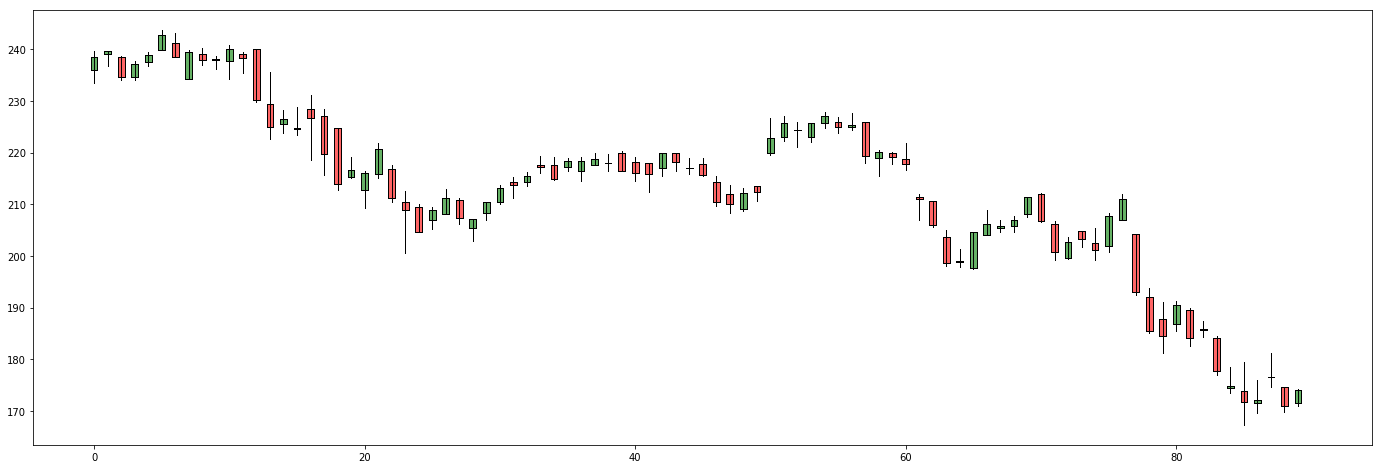

In [5]:
data = prices_adj.loc['BLK', ['open','close','high','low','volume']][:90]
fig = plt.figure(figsize=(24, 8))
ax = fig.add_subplot(1, 1, 1)
mpf.candlestick2_ochl(ax, data['open'], data['close'], data['high'], data['low'], width=0.5, colorup='green', colordown='red', alpha=0.6)

### Normalize the prices entries using the t-1 close price  
- Effectively it's the daily return calculated as the difference of the log(price)  
- The price movement is modeled as a Wiener process (aka a random walk) in this analysis. Under this assumption,  
    - Return has normal distribution
    - Sometimes people use the Poisson process to model jumps, I stick with Wiener process for its simplicity.  
- Log transformation is performed to calculate the return  
    - Normally $return = (price_{t} - price_{t-1}) / price_{t-1}$, it can be approximate as $return = log(price_{t})-log(price_{t-1})$. 
    - The later can be more efficiently calculated, especially when calculating the cumulative.

In [6]:
ret = prices_adj.copy()

# Log transfrom the prices   
for col in ['open','close','low','high']:
    ret[col] = np.log(ret[col])
    
# Get the close price of the previous day
ret['close_m1'] = ret['close'].shift(1)

# Calculate normalize the prices using t-1 close price
ret.eval("""
            open = open - close_m1
            close = close - close_m1
            high = high - close_m1
            low = low - close_m1
         """,
             inplace = True)

# Drop close_m1
ret.drop(labels=['close_m1'], axis='columns', inplace=True)

# Drop the first entry for each ticker
idx = ret.groupby('symbol').head(1).index
ret.drop(labels=idx, axis='index', inplace=True)

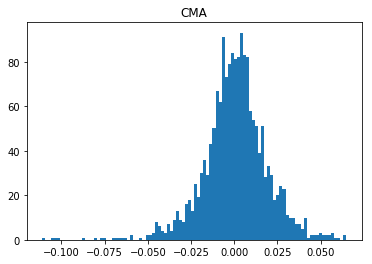

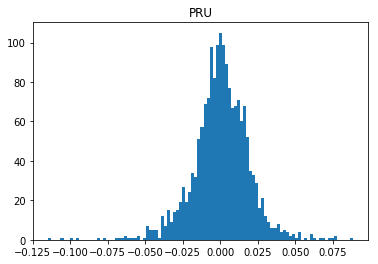

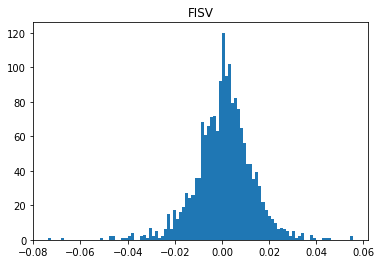

In [7]:
# The normal distribution assumption

for i in random.choices(symbols, k=3):
    plt.hist(ret.loc[i, 'close'], bins=100)
    plt.title(i)
    plt.show()

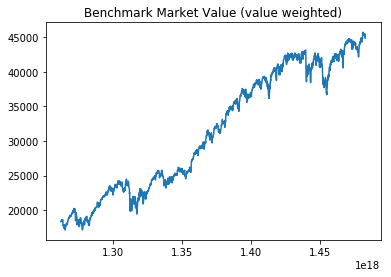

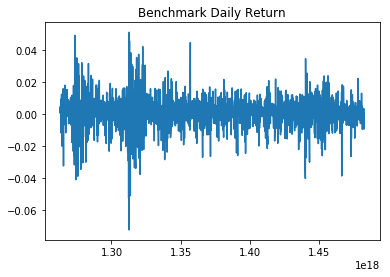

In [8]:
# Calculate the index return (baseline)

df = prices_adj.reset_index('symbol').sort_index()
bench = df.groupby(df.index)[['close']].sum()
plt.plot(bench)
plt.title("Benchmark Market Value (value weighted)")
plt.show()

bench_ret = np.log(bench) - np.log(bench.shift(1))
plt.plot(bench_ret)
plt.title("Benchmark Daily Return")
plt.show()

del(df)

In [9]:
# Calculate the daily active return (stock return - benchmark return)

ret = ret.swaplevel().sort_index()
ret['active'] = ret['close'] - bench_ret['close']

ret = ret.swaplevel().sort_index()

In [10]:
%%time
# Some feature engineering

def calc_features(symbol):
        
    df = ret.loc[[symbol]].copy()
        
    # Assign the daily return into buckets
#     df.loc[df['close']<=-0.05, 'ret_bucket_1'] = 1
#     df.loc[(df['close']>-0.05)&(df['close']<=-0.03), 'ret_bucket_2'] = 1
#     df.loc[(df['close']>-0.03)&(df['close']<=-0.01), 'ret_bucket_3'] = 1
#     df.loc[(df['close']>-0.01)&(df['close']<=0), 'ret_bucket_4'] = 1
#     df.loc[(df['close']>0)&(df['close']<=0.01), 'ret_bucket_5'] = 1
#     df.loc[(df['close']>0.01)&(df['close']<=0.03), 'ret_bucket_6'] = 1
#     df.loc[(df['close']>0.03)&(df['close']<=0.05), 'ret_bucket_7'] = 1
#     df.loc[df['close']>=0.05, 'ret_bucket_8'] = 1
#     df.fillna(0, axis=1, inplace=True)
    
    for period in [5, 10, 20, 30, 60, 90]:
        # Momentum (cumulative return of the previous n days)
        exec("""df['cum_ret_%s'] = df['close'].rolling(period).sum().values"""  % period)

        # Standard deviation
        exec("""df['std_%s'] = df['close'].rolling(period).std().values"""  % period)

        # relative volume (t0 : average over the period (t-n, t-1))
        exec("""df['vol_to_avg_%s'] = (df['volume'] / df['volume'].shift(1).rolling(period).mean()).values"""  % period)

        # relative volume (t0 : median over the period (t-n, t-1))
#         exec("""df['vol_to_med_%s'] = (df['volume'] / df['volume'].shift(1).rolling(period).median()).values"""  % period)

        # Highs and lows
        exec("""df['high_%s'] = df['high'].rolling(period).max().values"""  % period)
        exec("""df['low_%s'] = df['low'].rolling(period).min().values"""  % period)

    # Append previous 60 days' daily return
    for period in range(1, 61):
        exec("""df['close_t_m%s'] = df['close'].shift(period)"""  % period)
        exec("""df['open_t_m%s'] = df['open'].shift(period)"""  % period)
        exec("""df['high_t_m%s'] = df['high'].shift(period)"""  % period)
        exec("""df['low_t_m%s'] = df['low'].shift(period)"""  % period)
    
    return df

# Kick it off with multi threading
# out = Parallel(n_jobs=-1, backend="threading")(delayed(calc_features)(s) for s in symbols)

# If multi-threading is not working, run this instead
out = []
for s in symbols:
    out.append(calc_features(s))
    
    
features = pd.concat(out)
features.drop(['volume'], axis=1, inplace=True)
features = features.swaplevel().sort_index()
del(out)

JoblibMemoryError: JoblibMemoryError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\adpra\Anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...\Python36\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\adpra\Anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x05B15D30, file "C:\Us...n36\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\adpra\AppData\Roaming\Python\Python36\s...ges\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...\Python36\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\a...ython36\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...\Python36\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x05B15D30, file "C:\Us...n36\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\adpra\AppData\Roaming\Python\Python36\s...ges\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...\Python36\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\a...ython36\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         self.io_loop = ioloop.IOLoop.current()
    477         try:
--> 478             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    479         except KeyboardInterrupt:
    480             pass
    481 
    482 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\adpra\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 5
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 5), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 5)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\adpra\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=5)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\Users\adpra\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\Users\adpra\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    276         if self.control_stream:
    277             self.control_stream.on_recv(self.dispatch_control, copy=False)
    278 
    279         def make_dispatcher(stream):
    280             def dispatcher(msg):
--> 281                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    282             return dispatcher
    283 
    284         for s in self.shell_streams:
    285             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '%%time\n# Some feature engineering\n\ndef calc_feat...ures = features.swaplevel().sort_index()\ndel(out)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 18, 19, 17, 6, 940067, tzinfo=tzutc()), 'msg_id': '88077A088668437E84169F360B4D7D74', 'msg_type': 'execute_request', 'session': 'F977F3F9F1894A34980AD42EC5150604', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '88077A088668437E84169F360B4D7D74', 'msg_type': 'execute_request', 'parent_header': {}})
    227             self.log.warn("Unknown message type: %r", msg_type)
    228         else:
    229             self.log.debug("%s: %s", msg_type, msg)
    230             self.pre_handler_hook()
    231             try:
--> 232                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'F977F3F9F1894A34980AD42EC5150604']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '%%time\n# Some feature engineering\n\ndef calc_feat...ures = features.swaplevel().sort_index()\ndel(out)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 18, 19, 17, 6, 940067, tzinfo=tzutc()), 'msg_id': '88077A088668437E84169F360B4D7D74', 'msg_type': 'execute_request', 'session': 'F977F3F9F1894A34980AD42EC5150604', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '88077A088668437E84169F360B4D7D74', 'msg_type': 'execute_request', 'parent_header': {}}
    233             except Exception:
    234                 self.log.error("Exception in message handler:", exc_info=True)
    235             finally:
    236                 self.post_handler_hook()

...........................................................................
C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'F977F3F9F1894A34980AD42EC5150604'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '%%time\n# Some feature engineering\n\ndef calc_feat...ures = features.swaplevel().sort_index()\ndel(out)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 18, 19, 17, 6, 940067, tzinfo=tzutc()), 'msg_id': '88077A088668437E84169F360B4D7D74', 'msg_type': 'execute_request', 'session': 'F977F3F9F1894A34980AD42EC5150604', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '88077A088668437E84169F360B4D7D74', 'msg_type': 'execute_request', 'parent_header': {}})
    392         if not silent:
    393             self.execution_count += 1
    394             self._publish_execute_input(code, parent, self.execution_count)
    395 
    396         reply_content = self.do_execute(code, silent, store_history,
--> 397                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    398 
    399         # Flush output before sending the reply.
    400         sys.stdout.flush()
    401         sys.stderr.flush()

...........................................................................
C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='%%time\n# Some feature engineering\n\ndef calc_feat...ures = features.swaplevel().sort_index()\ndel(out)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '%%time\n# Some feature engineering\n\ndef calc_feat...ures = features.swaplevel().sort_index()\ndel(out)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('%%time\n# Some feature engineering\n\ndef calc_feat...ures = features.swaplevel().sort_index()\ndel(out)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('%%time\n# Some feature engineering\n\ndef calc_feat...ures = features.swaplevel().sort_index()\ndel(out)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='%%time\n# Some feature engineering\n\ndef calc_feat...ures = features.swaplevel().sort_index()\ndel(out)', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-10-1c2820afe46a>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 12f54b50, execution_c..._before_exec=None error_in_exec=None result=None>)
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])
   2855                 code = compiler(mod, cell_name, "single")
-> 2856                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x12B66548, file "<ipython-input-10-1c2820afe46a>", line 1>
        result = <ExecutionResult object at 12f54b50, execution_c..._before_exec=None error_in_exec=None result=None>
   2857                     return True
   2858 
   2859             # Flush softspace
   2860             if softspace(sys.stdout, 0):

...........................................................................
C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x12B66548, file "<ipython-input-10-1c2820afe46a>", line 1>, result=<ExecutionResult object at 12f54b50, execution_c..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x12B66548, file "<ipython-input-10-1c2820afe46a>", line 1>
        self.user_global_ns = {'In': ['', "import pandas as pd\nimport numpy as np\n#import t..._ipython().run_line_magic('matplotlib', 'inline')", '# !kaggle datasets download -d dgawlik/nyse -p ./datasets', 'fundamentals = pd.read_csv("./data/nyse/fundamen...ecurities.csv", parse_dates=[\'Date first added\'])', "symbols = sorted(prices_adj['symbol'].unique())\n...e, drop=True)\nprices_adj.sort_index(inplace=True)", "data = prices_adj.loc['BLK', ['open','close','hi...0.5, colorup='green', colordown='red', alpha=0.6)", "ret = prices_adj.copy()\n\n# Log transfrom the pri...\nret.drop(labels=idx, axis='index', inplace=True)", "# The normal distribution assumption\n\nfor i in r...lose'], bins=100)\n    plt.title(i)\n    plt.show()", '# Calculate the index return (baseline)\n\ndf = pr...tle("Benchmark Daily Return")\nplt.show()\n\ndel(df)', "# Calculate the daily active return (stock retur..._ret['close']\n\nret = ret.swaplevel().sort_index()", r"get_ipython().run_cell_magic('time', '', '# Some...s = features.swaplevel().sort_index()\ndel(out)')"], 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {}, 'Parallel': <class 'joblib.parallel.Parallel'>, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomForestRegressor': <class 'sklearn.ensemble.forest.RandomForestRegressor'>, '_': '', '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, ...}
        self.user_ns = {'In': ['', "import pandas as pd\nimport numpy as np\n#import t..._ipython().run_line_magic('matplotlib', 'inline')", '# !kaggle datasets download -d dgawlik/nyse -p ./datasets', 'fundamentals = pd.read_csv("./data/nyse/fundamen...ecurities.csv", parse_dates=[\'Date first added\'])', "symbols = sorted(prices_adj['symbol'].unique())\n...e, drop=True)\nprices_adj.sort_index(inplace=True)", "data = prices_adj.loc['BLK', ['open','close','hi...0.5, colorup='green', colordown='red', alpha=0.6)", "ret = prices_adj.copy()\n\n# Log transfrom the pri...\nret.drop(labels=idx, axis='index', inplace=True)", "# The normal distribution assumption\n\nfor i in r...lose'], bins=100)\n    plt.title(i)\n    plt.show()", '# Calculate the index return (baseline)\n\ndf = pr...tle("Benchmark Daily Return")\nplt.show()\n\ndel(df)', "# Calculate the daily active return (stock retur..._ret['close']\n\nret = ret.swaplevel().sort_index()", r"get_ipython().run_cell_magic('time', '', '# Some...s = features.swaplevel().sort_index()\ndel(out)')"], 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {}, 'Parallel': <class 'joblib.parallel.Parallel'>, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomForestRegressor': <class 'sklearn.ensemble.forest.RandomForestRegressor'>, '_': '', '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
C:\Users\adpra\Documents\MIDS\W207_Applied_Machine_Learning\MIDS-W207\Final_Project\W207_Final_Project\<ipython-input-10-1c2820afe46a> in <module>()
----> 1 get_ipython().run_cell_magic('time', '', '# Some feature engineering\n\ndef calc_features(symbol):\n        \n    df = ret.loc[[symbol]].copy()\n        \n    # Assign the daily return into buckets\n#     df.loc[df[\'close\']<=-0.05, \'ret_bucket_1\'] = 1\n#     df.loc[(df[\'close\']>-0.05)&(df[\'close\']<=-0.03), \'ret_bucket_2\'] = 1\n#     df.loc[(df[\'close\']>-0.03)&(df[\'close\']<=-0.01), \'ret_bucket_3\'] = 1\n#     df.loc[(df[\'close\']>-0.01)&(df[\'close\']<=0), \'ret_bucket_4\'] = 1\n#     df.loc[(df[\'close\']>0)&(df[\'close\']<=0.01), \'ret_bucket_5\'] = 1\n#     df.loc[(df[\'close\']>0.01)&(df[\'close\']<=0.03), \'ret_bucket_6\'] = 1\n#     df.loc[(df[\'close\']>0.03)&(df[\'close\']<=0.05), \'ret_bucket_7\'] = 1\n#     df.loc[df[\'close\']>=0.05, \'ret_bucket_8\'] = 1\n#     df.fillna(0, axis=1, inplace=True)\n    \n    for period in [5, 10, 20, 30, 60, 90]:\n        # Momentum (cumulative return of the previous n days)\n        exec("""df[\'cum_ret_%s\'] = df[\'close\'].rolling(period).sum().values"""  % period)\n\n        # Standard deviation\n        exec("""df[\'std_%s\'] = df[\'close\'].rolling(period).std().values"""  % period)\n\n        # relative volume (t0 : average over the period (t-n, t-1))\n        exec("""df[\'vol_to_avg_%s\'] = (df[\'volume\'] / df[\'volume\'].shift(1).rolling(period).mean()).values"""  % period)\n\n        # relative volume (t0 : median over the period (t-n, t-1))\n#         exec("""df[\'vol_to_med_%s\'] = (df[\'volume\'] / df[\'volume\'].shift(1).rolling(period).median()).values"""  % period)\n\n        # Highs and lows\n        exec("""df[\'high_%s\'] = df[\'high\'].rolling(period).max().values"""  % period)\n        exec("""df[\'low_%s\'] = df[\'low\'].rolling(period).min().values"""  % period)\n\n    # Append previous 60 days\' daily return\n    for period in range(1, 61):\n        exec("""df[\'close_t_m%s\'] = df[\'close\'].shift(period)"""  % period)\n        exec("""df[\'open_t_m%s\'] = df[\'open\'].shift(period)"""  % period)\n        exec("""df[\'high_t_m%s\'] = df[\'high\'].shift(period)"""  % period)\n        exec("""df[\'low_t_m%s\'] = df[\'low\'].shift(period)"""  % period)\n    \n    return df\n\n# Kick it off with multi threading\nout = Parallel(n_jobs=-1, backend="threading")(delayed(calc_features)(s) for s in symbols)\n    \nfeatures = pd.concat(out)\nfeatures.drop([\'volume\'], axis=1, inplace=True)\nfeatures = features.swaplevel().sort_index()\ndel(out)')

...........................................................................
C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\IPython\core\interactiveshell.py in run_cell_magic(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, magic_name='time', line='', cell='# Some feature engineering\n\ndef calc_features(sy...ures = features.swaplevel().sort_index()\ndel(out)')
   2126             # This will need to be updated if the internal calling logic gets
   2127             # refactored, or else we'll be expanding the wrong variables.
   2128             stack_depth = 2
   2129             magic_arg_s = self.var_expand(line, stack_depth)
   2130             with self.builtin_trap:
-> 2131                 result = fn(magic_arg_s, cell)
        result = undefined
        fn = <bound method ExecutionMagics.time of <IPython.core.magics.execution.ExecutionMagics object>>
        magic_arg_s = ''
        cell = '# Some feature engineering\n\ndef calc_features(sy...ures = features.swaplevel().sort_index()\ndel(out)'
   2132             return result
   2133 
   2134     def find_line_magic(self, magic_name):
   2135         """Find and return a line magic by name.

...........................................................................
C:\Users\adpra\Documents\MIDS\W207_Applied_Machine_Learning\MIDS-W207\Final_Project\W207_Final_Project\<decorator-gen-63> in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line='', cell='# Some feature engineering\n\ndef calc_features(sy...ures = features.swaplevel().sort_index()\ndel(out)', local_ns=None)

...........................................................................
C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\IPython\core\magic.py in <lambda>(f=<function ExecutionMagics.time>, *a=(<IPython.core.magics.execution.ExecutionMagics object>, '', '# Some feature engineering\n\ndef calc_features(sy...ures = features.swaplevel().sort_index()\ndel(out)', None), **k={})
    182     validate_type(magic_kind)
    183 
    184     # This is a closure to capture the magic_kind.  We could also use a class,
    185     # but it's overkill for just that one bit of state.
    186     def magic_deco(arg):
--> 187         call = lambda f, *a, **k: f(*a, **k)
        f = <function ExecutionMagics.time>
        a = (<IPython.core.magics.execution.ExecutionMagics object>, '', '# Some feature engineering\n\ndef calc_features(sy...ures = features.swaplevel().sort_index()\ndel(out)', None)
        k = {}
    188 
    189         if callable(arg):
    190             # "Naked" decorator call (just @foo, no args)
    191             func = arg

...........................................................................
C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\IPython\core\magics\execution.py in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line='', cell='# Some feature engineering\n\ndef calc_features(sy...ures = features.swaplevel().sort_index()\ndel(out)', local_ns=None)
   1233                 return
   1234             end = clock2()
   1235         else:
   1236             st = clock2()
   1237             try:
-> 1238                 exec(code, glob, local_ns)
        code = <code object <module> at 0x12B66F98, file "<timed exec>", line 3>
        glob = {'In': ['', "import pandas as pd\nimport numpy as np\n#import t..._ipython().run_line_magic('matplotlib', 'inline')", '# !kaggle datasets download -d dgawlik/nyse -p ./datasets', 'fundamentals = pd.read_csv("./data/nyse/fundamen...ecurities.csv", parse_dates=[\'Date first added\'])', "symbols = sorted(prices_adj['symbol'].unique())\n...e, drop=True)\nprices_adj.sort_index(inplace=True)", "data = prices_adj.loc['BLK', ['open','close','hi...0.5, colorup='green', colordown='red', alpha=0.6)", "ret = prices_adj.copy()\n\n# Log transfrom the pri...\nret.drop(labels=idx, axis='index', inplace=True)", "# The normal distribution assumption\n\nfor i in r...lose'], bins=100)\n    plt.title(i)\n    plt.show()", '# Calculate the index return (baseline)\n\ndf = pr...tle("Benchmark Daily Return")\nplt.show()\n\ndel(df)', "# Calculate the daily active return (stock retur..._ret['close']\n\nret = ret.swaplevel().sort_index()", r"get_ipython().run_cell_magic('time', '', '# Some...s = features.swaplevel().sort_index()\ndel(out)')"], 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {}, 'Parallel': <class 'joblib.parallel.Parallel'>, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomForestRegressor': <class 'sklearn.ensemble.forest.RandomForestRegressor'>, '_': '', '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, ...}
        local_ns = None
   1239             except:
   1240                 self.shell.showtraceback()
   1241                 return
   1242             end = clock2()

...........................................................................
C:\Users\adpra\Documents\MIDS\W207_Applied_Machine_Learning\MIDS-W207\Final_Project\W207_Final_Project\<timed exec> in <module>()

...........................................................................
C:\Users\adpra\Anaconda3\lib\site-packages\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object <genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
MemoryError                                        Wed Apr 18 15:18:24 2018
PID: 3932                 Python 3.6.3: C:\Users\adpra\Anaconda3\python.exe
...........................................................................
C:\Users\adpra\Anaconda3\lib\site-packages\joblib\parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function calc_features>, ('PNC',), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\adpra\Anaconda3\lib\site-packages\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function calc_features>
        args = ('PNC',)
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\adpra\Documents\MIDS\W207_Applied_Machine_Learning\MIDS-W207\Final_Project\W207_Final_Project\<timed exec> in calc_features(symbol='PNC')

...........................................................................
C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py in __getitem__(self=<pandas.core.indexing._LocIndexer object>, key=['PNC'])
   1368         else:
   1369             # we by definition only have the 0th axis
   1370             axis = self.axis or 0
   1371 
   1372             maybe_callable = com._apply_if_callable(key, self.obj)
-> 1373             return self._getitem_axis(maybe_callable, axis=axis)
        self._getitem_axis = <bound method _LocIndexer._getitem_axis of <pandas.core.indexing._LocIndexer object>>
        maybe_callable = ['PNC']
        axis = 0
   1374 
   1375     def _is_scalar_access(self, key):
   1376         raise NotImplementedError()
   1377 

...........................................................................
C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py in _getitem_axis(self=<pandas.core.indexing._LocIndexer object>, key=['PNC'], axis=0)
   1611             if not (isinstance(key, tuple) and isinstance(labels, MultiIndex)):
   1612 
   1613                 if hasattr(key, 'ndim') and key.ndim > 1:
   1614                     raise ValueError('Cannot index with multidimensional key')
   1615 
-> 1616                 return self._getitem_iterable(key, axis=axis)
        self._getitem_iterable = <bound method _NDFrameIndexer._getitem_iterable of <pandas.core.indexing._LocIndexer object>>
        key = ['PNC']
        axis = 0
   1617 
   1618             # nested tuple slicing
   1619             if is_nested_tuple(key, labels):
   1620                 locs = labels.get_locs(key)

...........................................................................
C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py in _getitem_iterable(self=<pandas.core.indexing._LocIndexer object>, key=['PNC'], axis=0)
   1122             return self.obj._take(inds, axis=axis, convert=False)
   1123         else:
   1124             # Have the index compute an indexer or return None
   1125             # if it cannot handle; we only act on all found values
   1126             indexer, keyarr = labels._convert_listlike_indexer(
-> 1127                 key, kind=self.name)
        key = ['PNC']
        self.name = 'loc'
   1128             if indexer is not None and (indexer != -1).all():
   1129                 return self.obj.take(indexer, axis=axis)
   1130 
   1131             # existing labels are unique and indexer are unique

...........................................................................
C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexes\multi.py in _convert_listlike_indexer(self=<class 'pandas.core.indexes.multi.MultiIndex'> instance, keyarr=array(['PNC'], dtype=object), kind='loc')
   1792 
   1793         # are we indexing a specific level
   1794         if indexer is None and len(keyarr) and not isinstance(keyarr[0],
   1795                                                               tuple):
   1796             level = 0
-> 1797             _, indexer = self.reindex(keyarr, level=level)
        _ = undefined
        indexer = None
        self.reindex = 'reindex'
        keyarr = array(['PNC'], dtype=object)
        level = 0
   1798 
   1799             # take all
   1800             if indexer is None:
   1801                 indexer = np.arange(len(self))

...........................................................................
C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexes\multi.py in reindex(self=<class 'pandas.core.indexes.multi.MultiIndex'> instance, target=Index(['PNC'], dtype='object'), method=None, level=0, limit=None, tolerance=None)
   1886                                                **attrs)
   1887             else:
   1888                 target = _ensure_index(target)
   1889             target, indexer, _ = self._join_level(target, level, how='right',
   1890                                                   return_indexers=True,
-> 1891                                                   keep_order=False)
   1892         else:
   1893             target = _ensure_index(target)
   1894             if self.equals(target):
   1895                 indexer = None

...........................................................................
C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexes\base.py in _join_level(self=<class 'pandas.core.indexes.multi.MultiIndex'> instance, other=Index(['PNC'], dtype='object'), level=0, how='right', return_indexers=True, keep_order=False)
   3311             left_lev_indexer = _ensure_int64(left_lev_indexer)
   3312             rev_indexer = lib.get_reverse_indexer(left_lev_indexer,
   3313                                                   len(old_level))
   3314 
   3315             new_lev_labels = algos.take_nd(rev_indexer, left.labels[level],
-> 3316                                            allow_fill=False)
   3317 
   3318             new_labels = list(left.labels)
   3319             new_labels[level] = new_lev_labels
   3320 

...........................................................................
C:\Users\adpra\AppData\Roaming\Python\Python36\site-packages\pandas\core\algorithms.py in take_nd(arr=array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...    -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64), indexer=FrozenNDArray([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, ...], dtype='int64'), axis=0, out=None, fill_value=0, mask_info=(None, False), allow_fill=False)
   1372         if arr.flags.f_contiguous and axis == arr.ndim - 1:
   1373             # minor tweak that can make an order-of-magnitude difference
   1374             # for dataframes initialized directly from 2-d ndarrays
   1375             # (s.t. df.values is c-contiguous and df._data.blocks[0] is its
   1376             # f-contiguous transpose)
-> 1377             out = np.empty(out_shape, dtype=dtype, order='F')
        out = None
        out_shape = (850763,)
        dtype = dtype('int64')
   1378         else:
   1379             out = np.empty(out_shape, dtype=dtype)
   1380 
   1381     func = _get_take_nd_function(arr.ndim, arr.dtype, out.dtype, axis=axis,

MemoryError: 
___________________________________________________________________________

### Define train and test data

Due to the nature of the panel data, the train and test data is splitted on a rolling basis. for example, during the training stage I use 01/05/2010's features as the X and 01/06/2010's return as the y to fit a model. To test this model, I need to use 01/06/2010's features as the test data and 01/07/2010's return as the test label to evaluate the model. This process is repeated for all the dates.

In [11]:
dates = features.reset_index()[['date']].drop_duplicates().reset_index(drop=True)
dates.rename_axis({'date': 'X_train'}, axis=1, inplace=True)
dates['y_train'] = dates['X_train'].shift(-1)
dates['X_test'] = dates['X_train'].shift(-1)
dates['y_test'] = dates['X_test'].shift(-1)
dates['trade_date'] = dates['X_test']
dates.set_index('trade_date', inplace=True)

dates.dropna(axis=0, inplace=True)

NameError: name 'features' is not defined

In [ ]:
dates.head()

In [ ]:
dates.tail()

In [ ]:
def train_test_split(date):

    X_train = features.loc[dates.loc[date, 'X_train']].dropna(axis=0)
    y_train = features.loc[dates.loc[date, 'y_train'],'open'].dropna(axis=0)
    X_test = features.loc[dates.loc[date, 'X_test']].dropna(axis=0)
    y_test = features.loc[dates.loc[date, 'y_test'],'open'].dropna(axis=0)

    # Keep only the symbols that are in both sets
    X_train = X_train.loc[X_train.index.intersection(y_train.index)].sort_index()
    y_train = y_train.loc[y_train.index.intersection(X_train.index)].sort_index()
    X_test = X_test.loc[X_test.index.intersection(y_test.index)].sort_index()
    y_test = y_test.loc[y_test.index.intersection(X_test.index)].sort_index()

    # Make a binary y (1 for positive return, 0 for negative return)
    y_bin_train = (y_train > 0) * 1
    y_bin_test = (y_test > 0) * 1

    return X_train.as_matrix(), y_train.as_matrix(), y_bin_train.as_matrix(), X_test.as_matrix(), y_test.as_matrix(), y_bin_test.as_matrix()
#     return X_train, y_train, y_bin_train, X_test, y_test, y_bin_test

### Baseline
The baseline strategy trades all the stocks overnight (buy at t0 close, sell at t+1 open), equal weighted.

In [ ]:
tmp = features.reset_index('symbol').loc[dates.index[90:], ['symbol', 'close']]

In [ ]:
# Calculate the baseline daily return
baseline = []
for date in tmp.index.unique():
    baseline.append([date, tmp.loc[date,'close'].mean()])
    
baseline = np.array(baseline)

In [ ]:
plt.plot(baseline[:,0], np.cumsum(baseline[:,1]))
plt.title("Baseline Cumulative Return")

### Random forest

#### Regressor

In [ ]:
%%time

def evaluate_rf_regr(date):
    X_train, y_train, y_bin_train, X_test, y_test, y_bin_test = train_test_split(date)
    regr = RandomForestRegressor(n_estimators=20, random_state=1, n_jobs=1, bootstrap=True, criterion='mse')
    
    try:
        regr.fit(X_train, y_train)
    except ValueError:
        return [date, np.nan, np.nan]
        
    y_pred = regr.predict(X_test)
    
    # Calculate the accuracy of the direction prediction
    accu_d = sum(y_pred * y_test > 0) / len(y_test)
    
    # Create a long only strategy to equally buy the stock with predicted positive overnight return
    if len(y_test[y_pred > 0]) > 0:
        strat_return = np.mean(y_test[y_pred > 0])
    else:
        strat_return = 0
    return [date, accu_d, strat_return]



# Kick it off with multi-threading
# out = Parallel(n_jobs=-1, backend="threading")(delayed(evaluate_rf_regr)(date) for date in dates.index[90:])


# Try this if multi-threading did not work
out = []
for date in dates.index:
    out.append(evaluate_rf_regr(date))


result_rf_regr = np.array(out)

In [ ]:
# Average accuracy for predicting direction
np.mean(result_rf_regr[:, 1])

In [ ]:
# Strategy cumulative return
plt.plot(result_rf_regr[:, 0], np.cumsum(result_rf_regr[:, 2]))
plt.title("Return - Random Forest Regression")

#### Classifier

In [ ]:
%%time

def evaluate_rf_clf(date):
    X_train, y_train, y_bin_train, X_test, y_test, y_bin_test = train_test_split(date)
    clf = RandomForestClassifier(n_estimators=40, random_state=1, n_jobs=1, bootstrap=True, criterion="gini")

    try:
        clf.fit(X_train, y_bin_train)
    except ValueError:
        return [date, np.nan, np.nan, np.nan, np.nan, np.nan]
        
    y_pred = clf.predict(X_test)
    
    # Calculate the precision of the direction prediction
    if sum(y_pred==1) > 0:
        prec_up = sum((y_pred==1)&(y_bin_test==1)) / sum(y_pred==1)
    else:
        prec_up = np.nan
    
    if sum(y_pred==0) > 0:
        prec_down = sum((y_pred==0)&(y_bin_test==0)) / sum(y_pred==0)
    else:
        prec_down = np.nan
    
    # Calculate the accuracy of correct predictions in either directions
    accu = sum(y_pred + y_bin_test != 1) / len(y_pred)
    
    # Create a long only strategy to equally buy the stocks with predicted positive overnight return
    if len(y_test[y_pred == 1]) > 0:
        ret_long = np.mean(y_test[y_pred==1])
    else:
        ret_long = 0

    # Create a long-short strategy to buy the stocks with predicted positive overnight return and short the stocks with predicted negative return
    if len(y_test[y_pred == 0]) > 0:
        ret_short = -np.mean(y_test[y_pred==0])
    else:
        ret_short = 0
        
    ret_ls = ret_long + ret_short
        
        
    return [date, prec_up, prec_down, accu, ret_long, ret_ls]


# Run with multi-threading
# out = Parallel(n_jobs=-1, backend="threading")(delayed(evaluate_rf_clf)(date) for date in dates.index[90:])


# Try this if multi-threading did not work
out = []
for date in dates.index[90:]:
    out.append(evaluate_rf_clf(date))

result_rf_clf = np.array(out)
del(out)

In [ ]:
## Average precision
# Up
print(np.nanmean(result_rf_clf[:, 1]))

# Down
print(np.nanmean(result_rf_clf[:, 2]))

## Average accuracy
print(np.nanmean(result_rf_clf[:, 3]))

In [ ]:
# Strategy cumulative return
plt.title("Return - Random Forest Classifier")
plt.plot(result_rf_clf[:, 0], np.cumsum(result_rf_clf[:, 4]))
plt.plot(result_rf_clf[:, 0], np.cumsum(result_rf_clf[:, 5]))
plt.legend(["Long only", "Long & short"])

### Logistic regression

In [ ]:
%%time

def evaluate_log_reg(date, C):
    X_train, y_train, y_bin_train, X_test, y_test, y_bin_test = train_test_split(date)
    clf = LogisticRegression(penalty='l2', tol=0.0001, C=C)
    
    try:
        clf.fit(X_train, y_bin_train)
    except ValueError:
        return [date, np.nan, np.nan]

    y_pred = clf.predict(X_test)

    # Calculate the accuracy of the direction prediction
    accu_d = sum(y_pred + y_bin_test != 1) / len(y_test)

    # Create a long only strategy to equally buy the stock with predicted positive overnight return
    if len(y_test[y_pred == 1]) > 0:
        strat_return = np.mean(y_test[y_pred == 1])
    else:
        strat_return = 0

    return [date, accu_d, strat_return]



# Find the best C value
max_accu = 0
C_max_accu = 0
max_ret = -1
C_max_ret = 0

for c in np.linspace(0.05, 1, 20):
#     out = Parallel(n_jobs=-1, backend="threading")(delayed(evaluate_log_reg)(date, c) for date in dates.index[90:])

    out = []
    for date in dates.index[90:]:
        out.append(evaluate_log_reg(date, c))
    
    result_log_reg = np.array(out)
    
    accu = np.nanmean(result_log_reg[:, 1])
    if accu > max_accu:
        max_accu = accu
        C_max_accu = c
        result_log_reg_max_accu = result_log_reg.copy()

    total_ret = np.nansum(result_log_reg[:, 2])
    if total_ret > max_ret:
        max_ret = total_ret
        C_max_ret = c
        result_log_reg_max_ret = result_log_reg.copy()
    
print(max_accu, C_max_accu, max_ret, C_max_ret)

In [ ]:
# Average accuracy for predicting direction
np.nanmean(result_log_reg[:, 1])

In [ ]:
# Strategy cumulative return

# Maximum accuracy
plt.plot(result_log_reg_max_accu[:, 0], np.nancumsum(result_log_reg_max_accu[:, 2]))
plt.title("Return - maximum accuracy")
plt.show()

# Maximum return
plt.plot(result_log_reg_max_ret[:, 0], np.nancumsum(result_log_reg_max_ret[:, 2]))
plt.title("Return - maximum return")

## Summary
Predicting the short term stock price direction is extremely difficult and there are no state of the art researching work available (you do not want to share your results if you manage to come up with a competative strategy). Our best results yield a ~50% prediction precision, which is no better than randomly guessing. In the future development, we will try to impelment the similar approach to predict the mid-term (e.g. 20-day) price movement direction.